# **FINE TUNING FASTER RCNN USING PYTORCH**

Hello Everyone!

In this Notebook I will show you how we can fine tune a Faster RCNN on the fruits images dataset. If you want to brush up about what is Faster RCNN, [here's](https://medium.com/@whatdhack/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd) an awesome medium article on the same.

The code is inspired by the Pytorch docs tutorial [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)


## Installs and Imports

Since a lot of code for object detection is same and has to be rewritten by everyone, torchvision contributers have provided us with helper codes for training, evaluation and transformations.

Let's clone the repo and copy the libraries into working directory

In [2]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 469869, done.
remote: Counting objects: 100% (50327/50327), done.
remote: Compressing objects: 100% (2345/2345), done.
remote: Total 469869 (delta 48053), reused 50124 (delta 47906), pack-reused 419542
Receiving objects: 100% (469869/469869), 923.23 MiB | 46.38 MiB/s, done.
Resolving deltas: 100% (437156/437156), done.
error: pathspec 'v0.3.0' did not match any file(s) known to git


Lets import the libraries

In [44]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import pickle

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


In [11]:
classes = [_, 'A10','A400M','AG600', 'B1','B2',
                        'B52','Be200','C130','C17','C5','E2','EF2000','F117','F14',
                        'F15','F16','F18','F22','F35','F4','J20','JAS39',
                        'MQ9','Mig31','Mirage2000','RQ4','Rafale','SR71',
                        'Su57','Tu160','Tu95','U2','US2','V22','Vulcan','XB70','YF23']

In [12]:
len(classes)

38

## Dataset

Lets build the Aircrafts images dataset!

In [24]:
### New Attempt w/ pickle

# defining the files directory and testing directory
files_dir = '/home/jupyter/images_gcs/det_modify/train'
test_dir = '/home/jupyter/images_gcs/det_modify/test'
val_dir = '/home/jupyter/images_gcs/det_modify/val'


train_pickle = '/home/jupyter/images_gcs/det_modify/label_train_df.pkl'
test_pickle = '/home/jupyter/images_gcs/det_modify/label_test_df.pkl'
val_pickle = '/home/jupyter/images_gcs/det_modify/label_val_df.pkl'

class AircraftsDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None, pickle_file='/home/jupyter/images_gcs/det_modify/label_train_df.pkl'):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        self.pickle_file = pickle_file

        self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-4:]=='.jpg']

        self.classes = [_, 'A10','A400M','AG600', 'B1','B2',
                        'B52','Be200','C130','C17','C5','E2','EF2000','F117','F14',
                        'F15','F16','F18','F22','F35','F4','J20','JAS39',
                        'MQ9','Mig31','Mirage2000','RQ4','Rafale','SR71',
                        'Su57','Tu160','Tu95','U2','US2','V22','Vulcan','XB70','YF23']

        # Load the pickle file (assuming it contains a Pandas DataFrame)
        with open(self.pickle_file, 'rb') as f:
            self.df = pickle.load(f)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0

        wt = img.shape[1]
        ht = img.shape[0]

        boxes = []
        labels = []
        areas = []

        # Filter for the current image and extract bounding boxes
        img_df = self.df[self.df['filename'] == img_name[:-4]]
        #print(img_df)
        for _, row in img_df.iterrows():
            labels.append(self.classes.index(row['class']))
            xmin = row['xmin']
            xmax = row['xmax']
            ymin = row['ymin']
            ymax = row['ymax']

            f_wt = row['width']
            f_ht = row['height']

            xmin_corr = (xmin / f_wt) * self.width
            xmax_corr = (xmax / f_wt) * self.width
            ymin_corr = (ymin / f_ht) * self.height
            ymax_corr = (ymax / f_ht) * self.height

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

            # Calculate the area
            area = (xmax_corr - xmin_corr) * (ymax_corr - ymin_corr)
            areas.append(area)  # Store the area

       # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        areas = torch.as_tensor(areas)



        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = areas
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:

            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)

            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])



        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = AircraftsDataset(files_dir, 640, 640)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[3]
print(img.shape, '\n',target)

length of dataset =  3717 

(640, 640, 3) 
 {'boxes': tensor([[138.6667, 130.5632, 534.4000, 495.0188]]), 'labels': tensor([15]), 'area': tensor([144227.2188]), 'iscrowd': tensor([0]), 'image_id': tensor([3])}


Points to be noted -
1. The dataset returns a tuple. The first element is the image shape and the second element is a dictionary.
2. The image is of the size, we provided while defining the dataset and the color mode is RGB.
3. There are four bounding boxes in the image which is evident from four lists in boxes and length of labels.

And its done!

Dataset building is one of the hardest things in the notebook. If you got till here while understand all of the above, you are doing pretty good!

Let's now see, what our data looks like. The function is inspired from [here](https://www.kaggle.com/kiwifairy/visualize-x-ray-image-with-bounding-boxes)

# Visualization

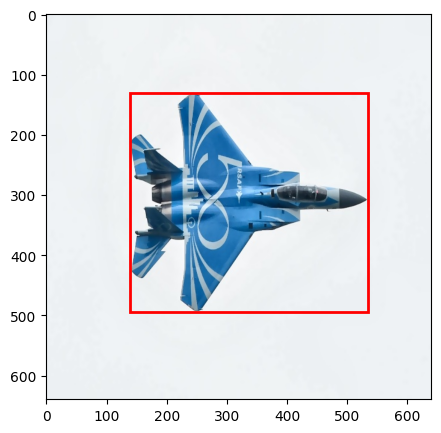

In [3]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

# plotting the image with bboxes. Feel free to change the index
img, target = dataset[3]
plot_img_bbox(img, target)

You can see that we are doing great till now, as the bbox is correctly placed.

One thing to note is that, the dataset wants us to predict only the full apple as "apple" but not the half cut one. This will be a challenge to overcome.

Lets build the model then!

# Model

We will define a function for loading the model. We will call it later

In [25]:

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

You can clearly see, how easy it is to load and prepare the model using pytorch

# Augmentations

This is where we can apply augmentations to the image.

The augmentations to object detection vary from normal augmentations becuase here we need to ensure that, bbox still aligns with the object correctly after transforming.

Here I have added random flip transform, feel free to customize it as you feel



In [26]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Preparing dataset

Now lets prepare datasets and dataloaders for training and testing.

In [125]:
# use our dataset and defined transformations
dataset = AircraftsDataset(files_dir, 640, 640, transforms= get_transform(train=True), pickle_file = train_pickle)
dataset_test = AircraftsDataset(val_dir, 640, 640, transforms= get_transform(train=False), pickle_file = val_pickle)

# split the dataset in train and test set
#torch.manual_seed(1)
#indices = torch.randperm(len(dataset)).tolist()

# train test split
#test_split = 0.2
#tsize = int(len(dataset)*test_split)
#dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


In [126]:
from pycocotools.coco import COCO

def get_coco_ground_truth(data_loader_test):
    coco_gt = COCO()
    categories = [
        {'id': 1, 'name': 'A10'},
        {'id': 2, 'name': 'A400M'},
        {'id': 3, 'name': 'AG600'},
        {'id': 4, 'name': 'B1'},
        {'id': 5, 'name': 'B2'},
        {'id': 6, 'name': 'B52'},
        {'id': 7, 'name': 'Be200'},
        {'id': 8, 'name': 'C130'},
        {'id': 9, 'name': 'C17'},
        {'id': 10, 'name': 'C5'},
        {'id': 11, 'name': 'E2'},
        {'id': 12, 'name': 'EF2000'},
        {'id': 13, 'name': 'F117'},
        {'id': 14, 'name': 'F14'},
        {'id': 15, 'name': 'F15'},
        {'id': 16, 'name': 'F16'},
        {'id': 17, 'name': 'F18'},
        {'id': 18, 'name': 'F22'},
        {'id': 19, 'name': 'F35'},
        {'id': 20, 'name': 'F4'},
        {'id': 21, 'name': 'J20'},
        {'id': 22, 'name': 'JAS39'},
        {'id': 23, 'name': 'MQ9'},
        {'id': 24, 'name': 'Mig31'},
        {'id': 25, 'name': 'Mirage2000'},
        {'id': 26, 'name': 'RQ4'},
        {'id': 27, 'name': 'Rafale'},
        {'id': 28, 'name': 'SR71'},
        {'id': 29, 'name': 'Su57'},
        {'id': 30, 'name': 'Tu160'},
        {'id': 31, 'name': 'Tu95'},
        {'id': 32, 'name': 'U2'},
        {'id': 33, 'name': 'US2'},
        {'id': 34, 'name': 'V22'},
        {'id': 35, 'name': 'Vulcan'},
        {'id': 36, 'name': 'XB70'},
        {'id': 37, 'name': 'YF23'}
    ]

    image_ids = []
    annotations = []
    ann_id = 1

    for image, target in data_loader_test:
        image_id = target[0]['image_id'].item()
        image_ids.append(image_id)

        boxes = target[0]['boxes'].numpy()
        labels = target[0]['labels'].numpy()

        for i in range(len(labels)):
            bbox = boxes[i].tolist()
            category_id = labels[i]
            annotation = {
                'id': ann_id,
                'image_id': image_id,
                'bbox': bbox,
                'area': target[0]['area'][i].item(),
                'iscrowd': target[0]['iscrowd'][i].item(),
                'category_id': category_id
            }
            annotations.append(annotation)
            ann_id += 1      

    # Create the COCO format ground truth instance
    coco_gt.dataset = {'images': [{'id': image_id} for image_id in image_ids],
                       'categories': categories, 
                       'annotations': annotations}
    coco_gt.createIndex()
    return coco_gt

In [127]:
def get_predictions(model, data_loader_test, device):  # Assuming 'self' refers to your model
    results = []
    image_ids = []
    model.eval()
    ann_id = 1

    for images, targets in data_loader_test:  
        images = list(image.to(device) for image in images)  

        with torch.no_grad():  
            outputs = model(images)

        for output, target in zip(outputs, targets):  
            scores = output['scores'].tolist()
            labels = output['labels'].tolist()
            boxes = output['boxes'].tolist()  
            image_id = target['image_id'].item()
            image_ids.append(image_id)

            for box, score, label in zip(boxes, scores, labels):
                width = box[2] - box[0]
                height = box[3] - box[1]
                area = width * height  
                result = {
                    'image_id': image_id,
                    'bbox': box,
                    'score': score,
                    'category_id': label,
                    'id' : ann_id,
                    'area' : area
                }
                results.append(result)
                ann_id += 1
    coco_dt = COCO()
    coco_dt.dataset = {'images':[{'id': image_id} for image_id in image_ids], 'annotations':results}
    coco_dt.createIndex()
    return coco_dt   

In [128]:
# Get the number of classes in your dataset
num_classes = 38 

# Load the pre-trained Faster R-CNN model 
model = get_object_detection_model(num_classes)

# Select device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the device

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [90]:
# Parameters to train (requires fine-tuning)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Optionally adjust the learning rate over time
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) 

# Training

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()  
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) 
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
    
    lr_scheduler.step()  # Update learning rate (if using a scheduler)
    print('Epoch Num Done:', epoch)
    # Evaluation phase
    with torch.no_grad():  
        model.eval()
        coco_gt = get_coco_ground_truth(data_loader_test)  # Construct COCO ground truth
        coco_dt = get_predictions(model, data_loader_test, device)        # Generate COCO-style predictions
        coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()


        print(f"mAP (IoU 0.5:0.95): {coco_eval.stats[0]}")


Epoch Num Done: 0
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.19s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.053
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets

In [131]:
torch.save(model, 'model_object_detection.pth')

An AP of 0.78-0.80 is not bad but perhaps we can make it even better with more augmentations, I will leave that to you.

# Decode predictions

Our model predicts a lot of bounding boxes per image, to take out the overlapping ones, We will use **Non Max Suppression** if you want to brush up on that, check [this](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) out.

Torchvision provides us a utility to apply nms to our predictions, lets build a function `apply_nms` using that.

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

# Testing our Model

Lets take an image from our test dataset and see, how our model does.

We will first see, how many bounding boxes does our model predict compared to actual

In [ ]:
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

Whoa! Thats a lot of bboxes. Lets plot them and check what did it predict

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

You can see that our model predicts a lot of bounding boxes for every apple. Lets apply nms to it and see the final output

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

Now lets take an image from the test set and try to predict on it

In [ ]:
test_dataset = FruitImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)

The model does well on single object images.

You can see that our model predicts the slices too and that means a failure ☹️ . But fear not, this is just a base line model here are some ideas we can improve it -
1. Use a better model.
   We have the option of changing the backbone of our model which at present is `resnet 50` and the fine tune it.
   
2. We can change the training configurations like size of the images, optimizers and learning rate schedule.
3. We can add more augmentations.
   We have used the Albumentations library which has an extensive library of data augmentation functions. Feel free to explore and try them out.

# Fin.

That's it for the notebook.

Please tell me if you have any suggestions to improve this kernel or if you find any errors. I will be glad to hear them.

If you find the notebook useful, Consider upvoting this kernel :)

In [94]:
def inference(self, data_loader_test): 
    results = []
    self.eval()  # Set model to evaluation mode

    for images, targets in data_loader_test:  
        images = list(image.to(self.device) for image in images)  # Move images to device

        with torch.no_grad():  # Disable gradient calculation for efficiency
            outputs = self(images)

        for output, target in zip(outputs, targets):  # Iterate over outputs and targets
            scores = output['scores'].tolist()
            labels = output['labels'].tolist()
            boxes = output['boxes'].tolist()  
            image_id = target['image_id'].item()

            for box, score, label in zip(boxes, scores, labels):
                result = {
                    'image_id': image_id,
                    'bbox': box,
                    'score': score,
                    'category_id': label
                }
                results.append(result)
    return results  